<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/quantumchemistry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="blue">**Quantum Computational Chemistry**

In [ ]:
!pip install pyscf geometric periodictable qutip cirq openfermion openfermionpyscf -q
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, hessian, dft, tddft, mp, cc
from pyscf.geomopt.geometric_solver import optimize
import scipy.optimize
import cirq
from openfermion import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_sparse_operator
from openfermionpyscf import run_pyscf

###### *Select or Define Molecule*

In [ ]:
# Helium (He)
mol = gto.Mole()
mol.atom = '''
    He 0.00 0.00 0.00
'''
molecule = 'Helium (He)'

In [ ]:
# Hydrogen (H₂)
mol = gto.Mole()
mol.atom = '''
    H  0.00 0.00  0.00
    H  0.00 0.00  0.74
'''
molecule = 'Hydrogen (H₂)'

In [ ]:
# Oxygen (O₂)
mol = gto.Mole()
mol.atom = '''
    O  0.00 0.00  0.00
    O  0.00 0.00  1.21
'''
molecule = 'Oxygen (O₂)'

In [ ]:
# Water (H₂O)
mol = gto.Mole()
mol.atom = '''
    O  0.000000  0.000000  0.000000
    H  0.000000  0.757000  0.586000
    H  0.000000 -0.757000  0.586000
'''
molecule = 'Water (H₂O)'

In [ ]:
# Nitrous Oxide (N₂O)
mol = gto.Mole()
mol.atom = '''
    N  0.00000000  0.00000000  -1.25324312
    N  0.00000000  0.00000000  -0.12244312
    O  0.00000000  0.00000000   1.06565688
'''
molecule = 'Nitrous Oxide (N₂O)'

In [ ]:
# Carbon Dioxide (CO₂)
mol = gto.Mole()
mol.atom = '''
    C   0.0000000   0.0000000   0.0000000
    O   0.0000000   0.0000000   1.1600000
    O   0.0000000   0.0000000  -1.1600000
'''
molecule = 'Carbon Dioxide (CO₂)'

In [ ]:
# Ammonia (NH₃)
mol = gto.Mole()
mol.atom = '''
    N  0.0000  0.0000  0.2000
    H  0.0000  0.9433 -0.2000
    H  0.8165 -0.4717 -0.2000
    H -0.8165 -0.4717 -0.2000
'''
molecule = 'Ammonia (NH₃)'

In [ ]:
# Phosphine (PH₃)
mol = gto.Mole()
mol.atom = '''
    P   0.00000000   0.00000000   0.24580000
    H   1.21850000   0.00000000  -0.57350000
    H  -0.60925000   1.05520000  -0.57350000
    H  -0.60925000  -1.05520000  -0.57350000
'''
molecule = 'Phosphine (PH₃)'

In [ ]:
# Methane (CH₄)
mol = gto.Mole()
mol.atom = '''
    C  0.000000  0.000000  0.000000
    H  0.629118  0.629118  0.629118
    H -0.629118 -0.629118  0.629118
    H -0.629118  0.629118 -0.629118
    H  0.629118 -0.629118 -0.629118
'''
molecule = 'Methane (CH₄)'

In [ ]:
# Methyl Chloride (CH₃Cl)
mol = gto.Mole()
mol.atom = '''
    C   0.00000000   0.00000000   0.45520100
    Cl  0.00000000   0.00000000  -1.31979900
    H   0.00000000   1.02669100   0.82520000
    H   0.88910000  -0.51334500   0.82520000
    H  -0.88910000  -0.51334500   0.82520000
'''
molecule = 'Methyl Chloride (CH₃Cl)'

In [ ]:
# Dimethyl Sulfide (DMS) (CH₃)₂S
mol = gto.Mole()
mol.atom = '''
    S   0.00000000   0.46519300   0.00000000
    C  -1.50853500  -0.34759700   0.00000000
    H  -1.48831900  -1.00619800   0.87783900
    H  -1.48831900  -1.00619800  -0.87783900
    H  -2.45862400   0.18760200   0.00000000
    C   1.50853500  -0.34759700   0.00000000
    H   1.48831900  -1.00619800   0.87783900
    H   2.45862400   0.18760200   0.00000000
    H   1.48831900  -1.00619800  -0.87783900
'''
molecule = 'Dimethyl Sulfide (DMS) (CH₃)₂S'

In [ ]:
# Dimethyl Disulfide (DMDS) (CH₃S)₂
mol = gto.Mole()
mol.atom = '''
    C  -1.579679   0.849405  -0.177006
    H  -1.516541   1.264210   0.829033
    H  -2.529898   0.315926  -0.297427
    H  -1.554032   1.528773  -1.031526
    S  -0.288210  -0.528464  -0.126027
    S   0.887210   0.334360   0.941620
    C   2.276901  -0.755146   0.505299
    H   2.331268  -1.526279   1.272183
    H   3.176472  -0.144865   0.413156
    H   2.199446  -1.196144  -0.487140
'''
molecule = 'Dimethyl Disulfide (DMDS) (CH₃S)₂'

In [ ]:
# Benzene (C₆H₆)
mol = gto.Mole()
mol.atom = '''
    C    0.000000    1.396763    0.000000
    C    1.209587    0.698382    0.000000
    C    1.209587   -0.698382    0.000000
    C    0.000000   -1.396763    0.000000
    C   -1.209587   -0.698382    0.000000
    C   -1.209587    0.698382    0.000000
    H    0.000000    2.480310    0.000000
    H    2.146325    1.240155    0.000000
    H    2.146325   -1.240155    0.000000
    H    0.000000   -2.480310    0.000000
    H   -2.146325   -1.240155    0.000000
    H   -2.146325    1.240155    0.000000
'''
molecule = 'Benzene (C₆H₆)'

In [ ]:
# Femoco Fe₄S₄ (Simplified Cube Model)
"""
Low Computational Cost. Fe₄S₄ clusters are common in biology (ferredoxins) and share basic Fe−S framework of FeMoco.
Lacks full MoFe₇ score, crucial Mo atom, central C atom, and all ligands.
Cannot accurately model unique electronic and magnetic properties or the catalytic function of the true FeMoco.
"""
mol = gto.Mole()
mol.atom = '''
    Fe   1.360   1.360   1.360
    Fe  -1.360  -1.360   1.360
    Fe  -1.360   1.360  -1.360
    Fe   1.360  -1.360  -1.360
    S   -2.280   0.000   0.000
    S    2.280   0.000   0.000
    S    0.000  -2.280   0.000
    S    0.000   2.280   0.000
'''
molecule = 'Femoco Fe₄S₄ (Simplified Cube Model)'
# Choose later mol.basis = 'lanl2dz'

In [ ]:
# FeMoco MoFe₇S₉C (Iron-Molybdenum Cofactor)
"""
FeMoco MoFe₇S₉C coordinates extracted from PDB 3U7Q (nitrogenase).
PDB 3U7Q is the entry code in the Protein Data Bank (PDB) for the atomic-resolution structure
of the nitrogenase Molybdenum-Iron (MoFe) protein from the bacterium Azotobacter vinelandii.

High Accuracy: uses experimentally derived coordinates (PDB 3U7Q), all essential metal (Mo, Fe) and bridging non-metal (S, C) atoms.
Modeling Active Site: It is minimal structure needed to capture the unique electronic and magnetic properties of FeMoco itself.
Limitations: still omits important protein-derived ligands (like homocitrate, histidine, and cysteine residues) that stabilize
the cluster and affect its electronic environment. It is also computationally demanding due to its size (MoFe₇S₉C).
"""
mol = gto.Mole()
mol.atom = '''
    Fe   2.832   0.521   0.234
    Fe   0.696   2.290   0.871
    Fe   0.590  -0.002   1.995
    Fe  -0.623   0.031  -0.384
    Fe   1.446  -1.731  -0.265
    Fe  -0.753  -2.181   0.879
    Fe  -1.076  -0.021  -2.830
    Mo  -2.851   0.046  -0.493
    S    1.218   0.512   0.158
    S   -0.887   1.980   0.543
    S    2.382  -0.015  -1.774
    S    0.928  -1.975  -2.202
    S   -1.172  -0.322  -4.669
    S   -2.379  -0.485   1.764
    S   -0.931  -2.028   2.816
    S    1.145  -2.058   1.674
    S    2.626   2.254   1.455
    C    0.027  -0.018  -0.008
'''
molecule = 'FeMoco MoFe₇S₉C (Iron-Molybdenum Cofactor)'

In [ ]:
# FeMoco MoFe₇S₉CN (Iron-Molybdenum Cofactor)
 # FeMoco with homocitrate ligand (more complete model)
"""
MoFe₇S₉C core with an added ligand proxy. The coordinates suggest the N atom is likely a simplified placeholder for the N
from the histidine (His) or homocitrate (h-citrate) ligand, which coordinates to the Mo atom.

This model attempts to account for the crucial ligand field effects from the surrounding protein environment without having
to include the entire protein (∼100,000 atoms).

The homocitrate ligand (represented by the 'N' in simplified list) is critical for FeMoco's stability and function.
Including its effect is vital for studying the catalytic cycle or reaction mechanism (e.g., substrate binding).

Computational trade-off: It is slightly larger and more expensive than MoFe₇S₉C, but it provides a more chemically complete description
for studying reactivity. mol.spin=0 and mol.charge=−3 also indicates attempt to model a specific, stable electronic state of biological system.
"""
mol = gto.Mole()
mol.atom = '''
    Mo  -3.446  -0.037  -0.011
    Fe  -1.164  -0.945  -1.371
    Fe  -0.983   1.637  -0.408
    Fe  -0.970  -0.406   1.646
    Fe   1.017   0.442  -1.605
    Fe   0.997  -1.635   0.444
    Fe   1.200   0.942   1.357
    Fe   3.431   0.028  -0.010
    S   -1.378   0.093  -3.219
    S   -2.656   1.799  -1.349
    S   -2.648  -1.885  -1.313
    S    0.788  -1.335  -2.447
    S   -2.625  -1.365   1.803
    S    0.751  -2.459   1.293
    S    2.669  -1.840   1.284
    S    2.685   1.877   1.316
    S    0.826   2.435  -1.311
    C    0.015  -0.003   0.006
    N   -5.312  -0.049  -0.018
'''
molecule = 'FeMoco MoFe₇S₉CN (Iron-Molybdenum Cofactor)'
# Choose later: mol.spin = 0 and mol.charge = -3 and

###### *Build Molecule*

In [ ]:
# Build molecule (with gto.M() function)
mol.atom = mol.atom
mol.basis = 'sto-3g'  # sto-3g, cc-pvdz, 6-31G, for transition metals: 'def2-svp', 'def2-tzvp', 'lanl2dz'
mol.ecp = False       # Set to = mol.basis for Femoco
mol.symmetry = True
mol.spin = False
mol.charge = False
#mol.verbose = 4
mol.build()

In [ ]:
def print_molecule_info(mol):
    print("="*50)
    print(f"Molecule Summary for {molecule}")
    print("="*50)
    print(f"Atoms: {mol.natm}")
    print(f"Electrons: {mol.nelectron}")
    print(f" Alpha electrons: {mol.nelec[0]}")
    print(f" Beta electrons: {mol.nelec[1]}")
    print(f"Basis: {mol.basis}")
    print(f"Basis functions: {mol.nao}")
    print(f"Charge: {mol.charge}")
    print(f"Spin (2S): {mol.spin}")
    print(f"Multiplicity (2S+1): {mol.spin + 1}")
    print(f"Nuclear repulsion energy: {mol.energy_nuc():.6f} Hartree")
    # Point group symmetry
    print(f"Top group: {mol.topgroup}")
    print(f"Group name: {mol.groupname}")
    print("\nAtom Coordinates (Angstrom):")
    for ia in range(mol.natm):
        symb = mol.atom_symbol(ia)
        coord = mol.atom_coord(ia) * 0.52917721067
        print(f"  {symb:2s}  {coord[0]:10.6f}  {coord[1]:10.6f}  {coord[2]:10.6f}")
    print("="*50)
print_molecule_info(mol)

Molecule Summary for Oxygen (O₂)
Atoms: 2
Electrons: 16
 Alpha electrons: 8
 Beta electrons: 8
Basis: sto-3g
Basis functions: 10
Charge: False
Spin (2S): False
Multiplicity (2S+1): 1
Nuclear repulsion energy: 27.989538 Hartree
Top group: Dooh
Group name: Dooh

Atom Coordinates (Angstrom):
  O     0.000000    0.000000    0.000000
  O     0.000000    0.000000    1.210000


###### *VQE (Variational Quantum Eigensolver)*

In [ ]:
# @title Quantum Ground State Calculation with UCCSD
import numpy as np
import scipy.optimize
import itertools
import cirq
from openfermion import MolecularData, FermionOperator
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_sparse_operator
from openfermionpyscf import run_pyscf
from pyscf import scf, dft, gto

# ==========================================
# 0. CONFIGURATION SWITCH
# ==========================================

# Choose your Ansatz here: 'UCCSD' or 'HEA' (Hardware Efficient, np.zeros + 0.01 initialization)
ANSATZ_TYPE = 'UCCSD'

# ==========================================
# 1. Classical Benchmarks (HF & DFT)
# ==========================================

print("="*50)
print(f"Ground State Calculation for {molecule}")
print("="*50)

print("\n--- Classical Benchmarks ---")

# Hartree-Fock
mf_hf = scf.RHF(mol)
mf_hf.verbose = 0
hf_energy = mf_hf.kernel()
print(f"Hartree-Fock Energy: {hf_energy:.6f} Ha")

# DFT (B3LYP)
mf_dft = dft.RKS(mol)
mf_dft.xc = 'B3LYP'
mf_dft.verbose = 0
dft_energy = mf_dft.kernel()
print(f"DFT (B3LYP) Energy:  {dft_energy:.6f} Ha")
print("-" * 30)

# ==========================================
# 2. Dynamic Bridge & Helpers
# ==========================================

def get_hamiltonian_from_mole(mol):
    """Bridging function: PySCF Mol -> OpenFermion QubitOperator"""
    n_atoms = mol.natm
    basis = mol.basis
    multiplicity = mol.spin + 1
    charge = mol.charge

    print(f"-> Bridging Molecule: {n_atoms} atoms, Basis: {basis}, Multiplicity: {multiplicity}")

    symbols = [mol.atom_symbol(i) for i in range(n_atoms)]
    coords = mol.atom_coords(unit='Angstrom')
    geometry = [[symbols[i], list(coords[i])] for i in range(n_atoms)]

    molecule_data = MolecularData(geometry, basis, multiplicity, charge)
    molecule_data = run_pyscf(molecule_data, run_scf=True)

    mh = molecule_data.get_molecular_hamiltonian()
    fh = get_fermion_operator(mh)
    qubit_hamiltonian = jordan_wigner(fh)

    return qubit_hamiltonian, molecule_data.n_qubits, molecule_data.n_electrons

def get_uccsd_excitations(n_orbitals, n_electrons):
    """Generates indices for Single and Double excitations."""
    occupied_indices = range(n_electrons)
    virtual_indices = range(n_electrons, n_orbitals)

    single_excitations = []
    double_excitations = []

    for i in occupied_indices:
        for a in virtual_indices:
            single_excitations.append((i, a))

    for i, j in itertools.combinations(occupied_indices, 2):
        for a, b in itertools.combinations(virtual_indices, 2):
            double_excitations.append((i, j, a, b))

    return single_excitations, double_excitations

# ==========================================
# 3. Ansatz Constructions
# ==========================================

def create_hea_ansatz(qubits, n_electrons, params):
    """Hardware Efficient Ansatz"""
    circuit = cirq.Circuit()
    # Init HF
    for i in range(n_electrons): circuit.append(cirq.X(qubits[i]))

    n_q = len(qubits)
    param_idx = 0

    # Layer 1: Ry
    for q in qubits:
        circuit.append(cirq.ry(params[param_idx])(q))
        param_idx += 1
    # Layer 2: CNOT
    for i in range(n_q - 1):
        circuit.append(cirq.CNOT(qubits[i], qubits[i+1]))
    # Layer 3: Ry
    for q in qubits:
        circuit.append(cirq.ry(params[param_idx])(q))
        param_idx += 1

    return circuit

def create_uccsd_ansatz(qubits, n_electrons, params, excitations):
    """
    Unitary Coupled Cluster Singles and Doubles (UCCSD) Ansatz.
    """
    circuit = cirq.Circuit()

    # 1. Initial State: Hartree-Fock
    for i in range(n_electrons):
        circuit.append(cirq.X(qubits[i]))

    # 2. Evolutions for Excitations
    param_idx = 0

    for exc in excitations:
        theta = params[param_idx]

        # Generator Construction
        if len(exc) == 2: # Single: i -> a
            i, a = exc
            generator = FermionOperator(((a, 1), (i, 0)), 1.0) - \
                        FermionOperator(((i, 1), (a, 0)), 1.0)
        elif len(exc) == 4: # Double: i,j -> a,b
            i, j, a, b = exc
            generator = FermionOperator(((b, 1), (a, 1), (j, 0), (i, 0)), 1.0) - \
                        FermionOperator(((i, 1), (j, 1), (a, 0), (b, 0)), 1.0)

        # Jordan-Wigner & Evolution
        qubit_generator = jordan_wigner(generator)
        for term, coeff in qubit_generator.terms.items():
            # Map to Cirq Pauli String
            pauli_map = {'X': cirq.X, 'Y': cirq.Y, 'Z': cirq.Z}
            qubit_pauli_map = {qubits[idx]: pauli_map[p_str] for idx, p_str in term}
            pauli_string = cirq.PauliString(qubit_pauli_map)

            # --- FIX FOR MODERN CIRQ ---
            # We want exp(theta * coeff * P).
            # Since generator is anti-hermitian, coeff is imaginary.
            # Cirq's P**t implements exp(i * pi * t * P).
            # We match the exponents: i * pi * t = theta * coeff
            # t = (theta * coeff.imag) / pi

            exponent = (theta * coeff.imag) / np.pi
            circuit.append(pauli_string ** exponent)

        param_idx += 1

    return circuit

# ==========================================
# 4. Cost Function & VQE Execution
# ==========================================

print("\n--- Starting VQE Calculation ---")
print(f"Method Selected: {ANSATZ_TYPE}")

# A. Setup System
qubit_hamiltonian, n_qubits, n_electrons = get_hamiltonian_from_mole(mol)
n_orbitals = n_qubits
n_spatial = n_qubits // 2
print(f"System: {n_qubits} Qubits, {n_electrons} Electrons, {n_spatial} Spatial Orbitals")

qubits = [cirq.LineQubit(i) for i in range(n_qubits)]
simulator = cirq.Simulator()

# B. Determine Parameters and Excitations
excitations = []
num_params = 0

if ANSATZ_TYPE == 'UCCSD':
    singles, doubles = get_uccsd_excitations(n_qubits, n_electrons)
    excitations = singles + doubles
    num_params = len(excitations)
    print(f"UCCSD Excitations: {len(singles)} Singles, {len(doubles)} Doubles")

    # UCCSD works best starting near zero (Hartree-Fock)
    initial_params = np.zeros(num_params) + 0.01

elif ANSATZ_TYPE == 'HEA':
    # 2 layers of rotations * n_qubits
    num_params = 2 * n_qubits
    print(f"HEA Parameters: {num_params}")

    # HEA works best with Random initialization
    initial_params = np.random.uniform(0, 2*np.pi, num_params)

print(f"Total Parameters to optimize: {num_params}")

# C. Optimization Loop
def cost_function(params):
    if ANSATZ_TYPE == 'UCCSD':
        circuit = create_uccsd_ansatz(qubits, n_electrons, params, excitations)
    else:
        circuit = create_hea_ansatz(qubits, n_electrons, params)

    result = simulator.simulate(circuit)
    state_vector = result.final_state_vector
    sparse_H = get_sparse_operator(qubit_hamiltonian)
    return np.vdot(state_vector, sparse_H.dot(state_vector)).real

print("Optimizing... (This may take longer for UCCSD)")
res = scipy.optimize.minimize(
    cost_function,
    initial_params,
    method='COBYLA',
    options={'maxiter': 3000, 'tol': 1e-6}
)

vqe_energy = res.fun
print(f"VQE Optimized Energy: {vqe_energy:.6f} Ha")

# ==========================================
# 5. Final Comparison
# ==========================================

print("\n--- Final Results Comparison ---")
print(f"Hartree-Fock: {hf_energy:.6f} Ha")
print(f"DFT (B3LYP):  {dft_energy:.6f} Ha")
print(f"VQE ({ANSATZ_TYPE}):   {vqe_energy:.6f} Ha")
print(f"Difference (VQE - HF): {vqe_energy - hf_energy:.6f} Ha")

Ground State Calculation for Hydrogen (H₂)

--- Classical Benchmarks ---
Hartree-Fock Energy: -1.116759 Ha
DFT (B3LYP) Energy:  -1.165418 Ha
------------------------------

--- Starting VQE Calculation ---
Method Selected: UCCSD
-> Bridging Molecule: 2 atoms, Basis: sto-3g, Multiplicity: 1
System: 4 Qubits, 2 Electrons, 2 Spatial Orbitals
UCCSD Excitations: 4 Singles, 1 Doubles
Total Parameters to optimize: 5
Optimizing... (This may take longer for UCCSD)
VQE Optimized Energy: -1.137284 Ha

--- Final Results Comparison ---
Hartree-Fock: -1.116759 Ha
DFT (B3LYP):  -1.165418 Ha
VQE (UCCSD):   -1.137284 Ha
Difference (VQE - HF): -0.020525 Ha


* **Feasiblity (examples):**
  * H₂ (STO-3G): 4 Qubits (Fast)
  * H₂O (STO-3G): ~14 Qubits (Slower to simulate)
  * O₂ (STO-3G): ~20 Qubits (Very slow on a laptop simulator)
* **Hartree-Fock** is a "Mean Field" approximation (The Baseline). It assumes electrons see each other as a static cloud of charge. It completely ignores **Electron Correlation** (how electrons instantly dodge each other). **The "Correlation Energy"** is the missing piece. It is the difference between the Hartree-Fock energy and the *True* energy (Full CI).
* **Ansatz used for the quantum circuit.**
  * VQE (Zeros + 0.01) with **HEE** (Hardware Efficient Ansatz). It went *lower* than Hartree-Fock. The difference (`-0.0205 Ha`) is exactly the **Correlation Energy** of the hydrogen molecule. This VQE run successfully used the entangling gates (CNOTs) to capture the quantum mechanical behavior that Hartree-Fock ignores. It is just a "blind guess" structure (Rotations + CNOTs). It doesn't know physics. It *can* find the correct answer, but it is inconsistent. **HEA** is a "blind" ansatz. It throws rotations and entanglements at the problem and hopes the optimizer finds a good path. It did a great job here (getting very close!), but UCCSD is more rigorous. It is a generic structure made of gates that are easy to run on quantum hardware (Rotations and CNOTs). Very easy to build; low circuit depth (good for noisy hardware). But it doesn't know any chemistry\! It's just "guessing" via brute force rotations. It often suffers from "Barren Plateaus" (where the optimizer gets stuck) as the system gets larger.
  * VQE with **UCCSD (Unitary Coupled Cluster) is theoretically superior to HEA.**. It is derived from physics. It specifically targets the "missing" electron correlations (excitations). **UCCSD** is designed based on the actual physics of electrons exciting between orbitals. It knows *which* electrons are allowed to interact. In chemistry, UCCSD is usually the "right" ansatz. It is physically derived from the Cluster Operator $e^{T - T^\dagger}$. It systematically excites electrons from occupied to unoccupied orbitals (Singles and Doubles excitations). It is chemically accurate and respects symmetries (number of electrons, spin, etc.). But it generates **huge** circuits (thousands of gates) that are very slow to simulate and impossible to run on current real hardware without error correction.
* **Evalution**: to want to know exactly how close we are to "perfection," we can run a **Full CI (FCI)** calculation. This diagonalizes the Hamiltonian directly (without a quantum circuit) to give the mathematically exact answer for this basis set.
* **Qubit Count** in the quantum algorithm (`System`):
  * In quantum chemistry, **1 Qubit = 1 Spin-Orbital**. Therefore, the number of spatial orbitals (which chemists usually refer to) is exactly half the number of qubits.
  * In the code, the qubit count/structure adjust with complexity automatically. However the "Circuit Depth" is fixed in the specific code.
  * **Qubit Count (Width)** scales automatically based on the **Basis Set** you choose in PySCF (`sto-3g`, `6-31g`, etc.) and the number of atoms.
      * **H₂ (STO-3G):** 2 atoms × 1 orbital each × 2 spins = **4 Qubits**.
      * **H₂ (6-31G):** 2 atoms × 2 orbitals each × 2 spins = **8 Qubits**.
      * **H₂O (STO-3G):** (2 H + 1 O) orbitals ... = **14 Qubits**.
      * *The code handles this automatically because `get_hamiltonian_from_mole` reads the basis size directly.*
  * **Circuit Structure (Depth):**
      * In **this specific code**, the structure is "Fixed Depth". We defined exactly one block of entanglers (CNOTs) sandwiched by rotations.
      * **The Problem:** For very complex molecules (strongly correlated systems), this simple structure might be too shallow to capture the complex physics. You would typically need to repeat the `Ry -> CNOT -> Ry` layers multiple times (e.g., `depth=3` or `depth=5`) to get an accurate result.

###### *Hartree-Fock (Slater Determinant)*

In [ ]:
# Ground State Energy with Hartree-Fock (Slater Determinant)
mol.verbose = 3   # Select 4 or 5 for more detail
mf = scf.RHF(mol)
mf.kernel()

converged SCF energy = -181.193323036266


np.float64(-181.19332303626595)

converged SCF energy = -181.193323036266


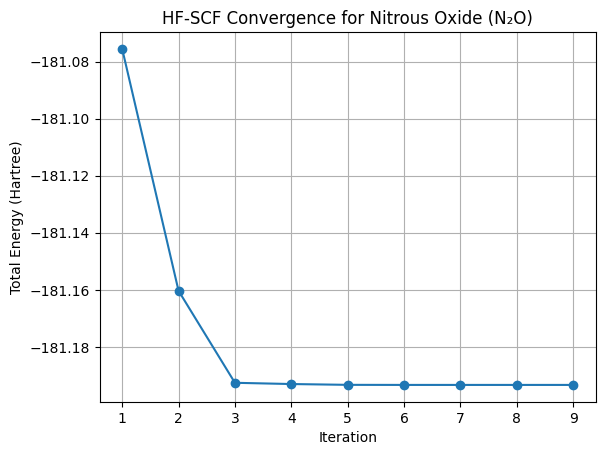

Ground state energy for Nitrous Oxide (N₂O): -181.193323036266 Hartree


In [ ]:
# Visualization of calculation process (Hartree-Fock)
mf = scf.RHF(mol)                         # Set method
conv_data = []                            # Store convergence data
def callback(envs):                       # Callback function to collect convergence information
    conv_data.append(envs['e_tot'])       # Captures energy values at each iteration to track process
mf.callback = callback                    # Set callback directly on the mf object
energy = mf.kernel()                      # Perform HF calculation
energies = conv_data                      # Extract energy values
iterations = range(1, len(energies) + 1)  # Extract iteration numbers
plt.plot(iterations, energies, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Total Energy (Hartree)')
plt.title(f'HF-SCF Convergence for {molecule}')
plt.grid(True)
plt.show()
print(f"Ground state energy for {molecule}: {energy} Hartree")

In [ ]:
# HF-SCF Core Hamiltonian matrix
# represents one-electron part of molecular Hamiltonian
# = kinetic energy operator of electrons and electrostatic attraction operator between electrons and nuclei
# Core Hamiltonian does not include electron-electron interactions

# Get the core Hamiltonian (kinetic + nuclear attraction)
core_hamiltonian = mf.get_hcore()
print("Core Hamiltonian matrix (Hcore):\n", core_hamiltonian)

Core Hamiltonian matrix (Hcore):
 [[-3.57206530e+02 -1.37885336e+02 -9.32527924e+00 ... -2.77615539e-01
   1.87801990e-01 -2.77614105e-01]
 [-1.37885336e+02 -1.43541757e+02 -3.44838147e+01 ... -5.92248500e-01
   4.00850790e-01 -5.92156820e-01]
 [-9.32527924e+00 -3.44838147e+01 -5.84726840e+01 ... -1.80590738e+00
   1.23604530e+00 -1.80097177e+00]
 ...
 [-2.77615539e-01 -5.92248500e-01 -1.80590738e+00 ... -3.67725389e+01
   3.46944695e-18 -6.20149928e-01]
 [ 1.87801990e-01  4.00850790e-01  1.23604530e+00 ...  3.46944695e-18
  -3.66217754e+01 -1.73472348e-18]
 [-2.77614105e-01 -5.92156820e-01 -1.80097177e+00 ... -6.20149928e-01
  -1.73472348e-18 -3.66310099e+01]]


In [ ]:
# HF-SCF Fock Matrix

# Fock matrix approximates many-electron wavefunction of system (H₂O),
# i.e. approximates interactions between electrons in a system to find an optimal set of orbitals.
# It gives snapshot of molecule electronic structure, incl. energies of molecular orbitals and how they interact or mix

# Get the Fock matrix (core Hamiltonian + electron-electron interaction terms)
fock_matrix = mf.get_fock()
print("Fock Matrix (Hartree-Fock Hamiltonian):\n", fock_matrix)

Fock Matrix (Hartree-Fock Hamiltonian):
 [[-0.26952032 -0.4694773   0.          0.         -0.29232224 -0.57287415
  -0.47752309  0.          0.          0.01409051]
 [-0.4694773  -0.28525187  0.          0.         -0.23467174 -0.47752309
  -0.30857326  0.          0.          0.21190859]
 [ 0.          0.          1.48384683  0.          0.          0.
   0.          0.44417828  0.          0.        ]
 [ 0.          0.          0.          1.48384683  0.          0.
   0.          0.          0.44417828  0.        ]
 [-0.29232224 -0.23467174  0.          0.          1.20567488 -0.01409051
  -0.21190859  0.          0.         -0.56096308]
 [-0.57287415 -0.47752309  0.          0.         -0.01409051 -0.26952032
  -0.4694773   0.          0.          0.29232224]
 [-0.47752309 -0.30857326  0.          0.         -0.21190859 -0.4694773
  -0.28525187  0.          0.          0.23467174]
 [ 0.          0.          0.44417828  0.          0.          0.
   0.          1.48384683  0.      

In [ ]:
print("Fock Matrix Shape:", fock_matrix.shape)
print("Fock Matrix Size:", fock_matrix.size)
print("Fock Matrix Dimension:", fock_matrix.ndim)
print("Fock Matrix Trace:", np.trace(fock_matrix))
print("Fock Matrix Determinant:", np.linalg.det(fock_matrix))
print("Fock Matrix Rank:", np.linalg.matrix_rank(fock_matrix))

Fock Matrix Shape: (10, 10)
Fock Matrix Size: 100
Fock Matrix Dimension: 2
Fock Matrix Trace: 7.237192699539285
Fock Matrix Determinant: -0.00786278789568637
Fock Matrix Rank: 10


In [ ]:
# HF-SCF Molecular Orbital Coefficients for All Orbitals (occupied and unoccupied)

# Retrieve Hartree-Fock orbitals (related to the Slater determinant) - occupied and unoccupied
# Occupied orbitals: contain electrons in Hartree-Fock ground state
# Virtual orbitals: unoccupied in ground state but can be important for excited state or post-Hartree-Fock methods like MP2 or CISD (electronic correlation effects)

# Get the molecular orbitals (which form the Slater determinant)
mo_coeff = mf.mo_coeff  # Coefficients of the molecular orbitals in the atomic basis
mo_energy = mf.mo_energy  # Orbital energies

print("Molecular Orbital Coefficients (MO coefficients):\n", mo_coeff)
print("Molecular Orbital Energies:\n", mo_energy)

Molecular Orbital Coefficients (MO coefficients):
 [[ 0.40366476  0.15024403 -0.70010768 -0.76067424  0.          0.
  -0.44372807  0.          0.          2.68617997]
 [ 0.17376287  1.95865624  0.7263728   1.6173428   0.          0.
   0.22106467  0.          0.          0.05058434]
 [ 0.          0.          0.          0.          0.          0.57904425
   0.          0.99134997  0.          0.        ]
 [ 0.          0.          0.          0.          0.57904425  0.
   0.          0.          0.99134997  0.        ]
 [ 0.02249745  0.01425354 -0.0112663   0.41021821  0.          0.
   0.72690133  0.          0.          2.02675347]
 [ 0.40366476 -0.15024403 -0.70010768  0.76067424  0.          0.
  -0.44372807  0.          0.         -2.68617997]
 [ 0.17376287 -1.95865624  0.7263728  -1.6173428   0.          0.
   0.22106467  0.          0.         -0.05058434]
 [ 0.          0.          0.          0.          0.          0.57904425
   0.         -0.99134997  0.          0.       

In [ ]:
# HF-SCF Molecular Orbital Coefficients for only occupied orbitals

# Extract and display the occupied molecular orbitals - used to construct Slater determinant - Only occupied orbitals
# The mo_occ variable stores the occupation numbers, which are usually 2 for occupied orbitals
# in a closed-shell Hartree-Fock calculation (since there are two electrons per orbital in a closed-shell system).
# By identifying which orbitals are occupied using np.where(mo_occ > 0),
# the code extracts the coefficients corresponding to those occupied orbitals and prints them.

mo_coeff = mf.mo_coeff # Get molecular orbital coefficients
mo_occ = mf.mo_occ # Get occupation numbers (from orbitals)
occupied_indices = np.where(mo_occ > 0)[0] # Identify indices of occupied orbitals
occupied_mo_coeff = mo_coeff[:, occupied_indices] # Coefficients of occupied molecular orbitals
print("Occupied Molecular Orbital Coefficients:")
print(occupied_mo_coeff)

Occupied Molecular Orbital Coefficients:
[[ 0.40366476]
 [ 0.17376287]
 [ 0.        ]
 [ 0.        ]
 [ 0.02249745]
 [ 0.40366476]
 [ 0.17376287]
 [ 0.        ]
 [ 0.        ]
 [-0.02249745]]


###### *Density Functional (DFT-SCF with Kohn-Sham)*

In [ ]:
# Ground State Energy with DFT (Kohn-Sham)
mf = dft.RKS(mol)  # Restricted Kohn Sham (often for closed shell systems)
mf.xc = 'B3LYP'    # Exchange-correlation functional
mf.kernel()        # perform DFT calculation and return energy

converged SCF energy = -6574.53377949503


np.float64(-6574.53377949503)

In [ ]:
# DFT-SCF  Kohn-Sham Hamiltonian (First Quantization) includes exchange-correlation potential, which approximates exchange and correlation effects
# Kohn-Sham formalism transforms complex many-electron problem into a simpler set of equations that describe non-interacting electrons
# but in presence of an effective potential that accounts for the effects of electron-electron interactions.

# Get the Kohn-Sham Hamiltonian (core Hamiltonian + exchange-correlation potential)
ks_hamiltonian = mf.get_hcore() + mf.get_veff()

print("Kohn-Sham Hamiltonian matrix:\n", ks_hamiltonian)

Kohn-Sham Hamiltonian matrix:
 [[-2.09806815e-01 -3.47338931e-01  6.93889390e-18  1.38777878e-17
  -1.92848152e-01 -4.04898835e-01 -3.36157374e-01  0.00000000e+00
   0.00000000e+00  3.45602668e-02]
 [-3.47338931e-01 -2.13556575e-01  0.00000000e+00 -6.93889390e-18
  -1.49603932e-01 -3.36157374e-01 -2.24561957e-01 -2.77555756e-17
  -1.04083409e-17  1.53804087e-01]
 [ 6.93889390e-18  0.00000000e+00  1.23446963e+00 -1.82641465e-18
   9.10729825e-18  3.46944695e-18  1.73472348e-17  3.29646425e-01
   8.30812639e-18  1.73472348e-17]
 [ 1.38777878e-17 -6.93889390e-18 -1.82641465e-18  1.23446963e+00
  -8.67361738e-19  1.04083409e-17 -3.46944695e-18  8.68558545e-18
   3.29646425e-01  1.38777878e-17]
 [-1.92848152e-01 -1.49603932e-01  9.10729825e-18 -8.67361738e-19
   9.94853139e-01 -3.45602668e-02 -1.53804087e-01 -6.93889390e-18
  -6.93889390e-18 -5.20251591e-01]
 [-4.04898835e-01 -3.36157374e-01  3.46944695e-18  1.04083409e-17
  -3.45602668e-02 -2.09806815e-01 -3.47338931e-01 -1.38777878e-17
  

In [ ]:
print("Kohn-Sham Hamiltonian Matrix Shape:", ks_hamiltonian.shape)
print("Kohn-Sham Hamiltonian Matrix Size:", ks_hamiltonian.size)
print("Kohn-Sham Hamiltonian Matrix Dimension:", ks_hamiltonian.ndim)
print("Kohn-Sham Hamiltonian Matrix Trace:", np.trace(ks_hamiltonian))
print("Kohn-Sham Hamiltonian Matrix Determinant:", np.linalg.det(ks_hamiltonian))
print("Kohn-Sham Hamiltonian Matrix Rank:", np.linalg.matrix_rank(ks_hamiltonian))

Kohn-Sham Hamiltonian Matrix Shape: (10, 10)
Kohn-Sham Hamiltonian Matrix Size: 100
Kohn-Sham Hamiltonian Matrix Dimension: 2
Kohn-Sham Hamiltonian Matrix Trace: 6.08085800033746
Kohn-Sham Hamiltonian Matrix Determinant: -0.00043849081832920506
Kohn-Sham Hamiltonian Matrix Rank: 10


###### *Coupled Cluster (Post Hartree Fock)*

Very accurate (often considered the "gold standard" for single-reference methods). CCSD (singles and doubles), CCSD(T) (includes perturbative triples). CCSD(T) is highly accurate but scales poorly with system size. <font color="blue">*Almost exclusively formulated and implemented in second quantization due to its complexity.*</font>

In [ ]:
# Ground State Energy with Coupled Cluster (Post Hartree Fock)
"""
Very accurate (often considered the "gold standard" for single-reference methods).
CCSD (singles and doubles), CCSD(T) (includes perturbative triples).
CCSD(T) is highly accurate but scales poorly with system size.
Almost exclusively formulated and implemented in second quantization due to its complexity.
"""
mf = scf.RHF(mol)                  # Perform a HF-SCF calculation to obtain the reference wavefunction
hf_energy = mf.kernel()
ccsd_calc = cc.CCSD(mf)            # Perform a Coupled Cluster calculation
ccsd_energy = ccsd_calc.kernel()
ccsd_t_energy = ccsd_calc.ccsd_t() # (Optional) Include perturbative triple excitations (CCSD(T))

# Ensure that ccsd_t_energy is a scalar (take the first element if it's an array)
if isinstance(ccsd_t_energy, (list, tuple)) or hasattr(ccsd_t_energy, "__len__"):
    ccsd_t_energy = ccsd_t_energy[0]  # Take the first value if it returns multiple results

# Print the results
print(f"HF-SCF energy: {hf_energy} Hartree")
print(f"CCSD energy: {ccsd_energy} Hartree")
#print(f"CCSD(T) energy: {ccsd_energy + ccsd_t_energy} Hartree")

converged SCF energy = -1.12870009355644
E(CCSD) = -1.163374496404819  E_corr = -0.03467440284837722
CCSD(T) correction = 3.99717015393741e-19
HF-SCF energy: -1.128700093556442 Hartree
CCSD energy: (np.float64(-0.034674402848377216), array([[ 3.39540587e-16, -5.97110968e-03, -2.44502512e-17,
         0.00000000e+00,  0.00000000e+00, -4.15377664e-03,
         0.00000000e+00,  0.00000000e+00,  3.61149362e-18]]), array([[[[-5.34108771e-02, -2.87498266e-17,  4.71221663e-02,
           0.00000000e+00,  0.00000000e+00,  3.54975293e-17,
           0.00000000e+00,  0.00000000e+00, -6.09039779e-03],
         [-2.87498266e-17, -5.07200622e-02, -2.20153962e-17,
           0.00000000e+00,  0.00000000e+00,  1.41940469e-02,
           0.00000000e+00,  0.00000000e+00,  3.01105216e-17],
         [ 4.71221663e-02, -2.20153962e-17, -5.31524971e-02,
           0.00000000e+00,  0.00000000e+00, -6.04008858e-19,
           0.00000000e+00,  0.00000000e+00,  1.04839327e-02],
         [ 0.00000000e+00,  0.0000

###### *Møller-Plesset Perturbation Theory (Post Hartree Fock)*

In [ ]:
# Ground State Energy with Møller-Plesset Perturbation Theory (Post Hartree Fock)
mf = scf.RHF(mol)
mf.kernel()
mp2 = mp.MP2(mf) # MP2 single point energy calculation
energy_mp2 = mp2.kernel()
print(f"MP2 energy: {energy_mp2[0]} Hartree")

converged SCF energy = -1.12870009355644
E(RMP2) = -1.15507165119134  E_corr = -0.0263715576348957
E(SCS-RMP2) = -1.16034596271832  E_corr = -0.0316458691618748
MP2 energy: -0.026371557634895678 Hartree


###### *Configuration Interaction (Post Hartree Fock)*

In [ ]:
from pyscf import tdscf  # For CIS calculations (using TDHF)
from pyscf import ci     # For CISD calculations
from pyscf import fci    # For FCI calculations

"""
* CIS calculation: PySCF doesn't have a direct ci.CIS module. Instead, we use the Time-Dependent Hartree-Fock (TDHF) approach with the Tamm-Dancoff Approximation (TDA), which is equivalent to CIS for excited states.
* Wavefunction analysis: this is a simplified analysis of the CISD wavefunction by directly summing over the appropriate coefficients.

This script performs:
1. Hartree-Fock (HF) calculation as the reference
2. Configuration Interaction Singles (CIS)
3. Configuration Interaction Singles and Doubles (CISD)
4. Full Configuration Interaction (FCI) - note this is very computationally expensive

The code also analyzes the CISD wavefunction to show the contributions from the reference determinant, single excitations, and double excitations.

A few important notes:
- **CIS is primarily used for excited states, not ground state correlation energy (the first excited state energy is reported)**
- CISD includes single and double excitations and is commonly used for ground state calculations
- FCI is the exact solution within the given basis set but scales factorially with system size
- For larger molecules, you may want to use truncated CI methods or other approaches like CASCI (Complete Active Space CI)
"""

# Step 1: Perform a HF-SCF calculation to obtain the reference wavefunction
mf = scf.RHF(mol)
hf_energy = mf.kernel()
print(f"HF-SCF energy: {hf_energy:.8f} Hartree")

# Step 2: Perform Configuration Interaction calculations

# CIS (Using TDHF which is equivalent to CIS for singlet excited states)
cis_calc = tdscf.TDA(mf)  # TDA approximation is equivalent to CIS
cis_e, cis_v = cis_calc.kernel()
cis_energy = cis_e[0] + hf_energy  # First excited state energy

# CISD
cisd_calc = ci.CISD(mf)
cisd_energy = cisd_calc.kernel()[0]  # Get the ground state energy

# FCI - Note: This can be very computationally expensive
cisolver = fci.FCI(mf)
fci_energy = cisolver.kernel()[0]

# Print the results
print(f"Molecule: {molecule}")
print(f"Basis Set: {mol.basis}")
print(f"HF-SCF energy: {hf_energy:.8f} Hartree")
print(f"CIS excited state energy: {cis_energy:.8f} Hartree")
print(f"CIS excitation energy: {cis_e[0]:.8f} Hartree")
print(f"CISD correlation energy: {cisd_energy - hf_energy:.8f} Hartree")
print(f"CISD total energy: {cisd_energy:.8f} Hartree")
print(f"FCI correlation energy: {fci_energy - hf_energy:.8f} Hartree")
print(f"FCI total energy: {fci_energy:.8f} Hartree")

# Analyze the CISD wavefunction
cisd_coeff = cisd_calc.ci
print("\nCISD Wavefunction Analysis:")
print(f"Reference determinant weight: {cisd_coeff[0]**2:.6f}")

# Calculate contributions from singles and doubles
#from pyscf.ci import cisd_slow
nelec = mol.nelectron
nocc = nelec // 2
nvir = mf.mo_coeff.shape[1] - nocc

# Get singles and doubles contribution
singles_norm = 0
doubles_norm = 0

# Singles contribution
singles_norm = sum(abs(cisd_coeff[i])**2 for i in range(1, nocc*nvir+1))

# Doubles contribution
doubles_norm = sum(abs(cisd_coeff[i])**2 for i in range(nocc*nvir+1, len(cisd_coeff)))

print(f"Singles contribution: {singles_norm:.6f}")
print(f"Doubles contribution: {doubles_norm:.6f}")
print(f"Total normalization check: {cisd_coeff[0]**2 + singles_norm + doubles_norm:.6f}")

converged SCF energy = -1.12870009355644
HF-SCF energy: -1.12870009 Hartree
Excited State energies (eV)
[14.07567057 21.45479287 32.30709355]
E(RCISD) = -1.163374490318234  E_corr = -0.03467439676179211
Molecule: Hydrogen (H₂)
Basis Set: cc-pvdz
HF-SCF energy: -1.12870009 Hartree
CIS excited state energy: -0.61142874 Hartree
CIS excitation energy: 0.51727136 Hartree
CISD correlation energy: 1.09402570 Hartree
CISD total energy: -0.03467440 Hartree
FCI correlation energy: -0.03467440 Hartree
FCI total energy: -1.16337449 Hartree

CISD Wavefunction Analysis:
Reference determinant weight: 0.983138
Singles contribution: 0.000052
Doubles contribution: 0.016758
Total normalization check: 0.999948


###### *Geometry Optimization (HF or DFT)*

In [ ]:
# Geometry Optimization (in Angstroms) with HF or DFT
from pyscf import gto, dft
from pyscf.geomopt.geometric_solver import optimize

# Define the molecule with a rough guess for geometry (initial atomic positions)
# These positions don't need to be exact, as the optimization will refine them
mol.atom = mol.atom
mol.basis = mol.basis
mol.build()

# Take molecule including basis set defined from `mol.build()`
mf = dft.RKS(mol)     # Perform geometry optimization using DFT (Restricted Kohn-Sham)
mf.xc = 'b3lyp'       # Define the exchange-correlation functional
mol_eq = optimize(mf)

# Print optimized coordinates. This geometry corresponds to lowest energy configuration found during optimization process
print("Optimized Geometry (in Angstroms):")
print(mol_eq.atom_coords())

geometric-optimize called with the following command line:
/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-ae64ed8a-9a3a-4ae4-9549-db57adcde7fa.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********    


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H   0.000000   0.000000   0.000000    0.000000  0.000000  0.000000
   H   0.000000   0.000000   0.740000    0.000000  0.000000  0.000000

WARN: Unable to to identify input symmetry using original axes.
Different symmetry axes will be used.


WARN: Mole.unit (angstrom) is changed to Bohr

converged SCF energy = -1.17328112090857
--------------- SymAdaptedRKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000     0.0000000000     0.0159964150
1 H     0.0000000000     0.0000000000    -0.0159964150
----------------------------------------------
cycle 1: E = -1.17328112091  dE = -1.17328  norm(grad) = 0.0226223


Step    0 : Gradient = 1.600e-02/1.600e-02 (rms/max) Energy = -1.1732811209
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 3.91394e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H   0.000000   0.000000  -0.010814    0.000000  0.000000  0.359186
   H   0.000000   0.000000   0.750814    0.000000  0.000000  0.380814
converged SCF energy = -1.17360206558998
--------------- SymAdaptedRKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000     0.0000000000     0.0000664006
1 H     0.0000000000     0.0000000000    -0.0000664006
----------------------------------------------
cycle 2: E = -1.17360206559  dE = -0.000320945  norm(grad) = 9.39046e-05


Step    1 : Displace = 1.081e-02/1.081e-02 (rms/max) Trust = 1.000e-01 (=) Grad = 6.640e-05/6.640e-05 (rms/max) E (change) = -1.1736020656 (-3.209e-04) Quality = 0.982
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 3.89770e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H   0.000000   0.000000  -0.010859    0.000000  0.000000  0.369955
   H   0.000000   0.000000   0.750859    0.000000  0.000000  0.370045
converged SCF energy = -1.17360207162442
--------------- SymAdaptedRKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000     0.0000000000     0.0000045661
1 H     0.0000000000     0.0000000000    -0.0000045661
----------------------------------------------
cycle 3: E = -1.17360207162  dE = -6.03443e-09  norm(grad) = 6.45747e-06


Step    2 : Displace = 4.507e-05/4.507e-05 (rms/max) Trust = 1.414e-01 (+) Grad = 4.566e-06/4.566e-06 (rms/max) E (change) = -1.1736020716 (-6.034e-09) Quality = 1.067
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 3.89770e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 2.354 seconds


Optimized Geometry (in Angstroms):
[[ 0.          0.         -0.71971902]
 [ 0.          0.          0.71971902]]


###### *Calculate excited electronic states*

In [ ]:
# Calculate excited electronic states
myhf = scf.RHF(mol).run()     # Perform a ground-state calculation
mytd = tddft.TDA(myhf).run()  # Excited-state calculation using TDDFT
#mol = gto.M(verbose = 4)     # Add verbose for more details
mytd.analyze()

converged SCF energy = -1.12870009355644
Excited State energies (eV)
[14.07567057 21.45479287 32.30709355]

** Singlet excitation energies and oscillator strengths **
Excited State   1:  A1u     14.07567 eV     88.08 nm  f=0.6152
Excited State   2:  A1g     21.45479 eV     57.79 nm  f=0.0000
Excited State   3:  A1u     32.30709 eV     38.38 nm  f=0.2024


###### *Emission and Absorption Spectra*

converged SCF energy = -1.12870009355644


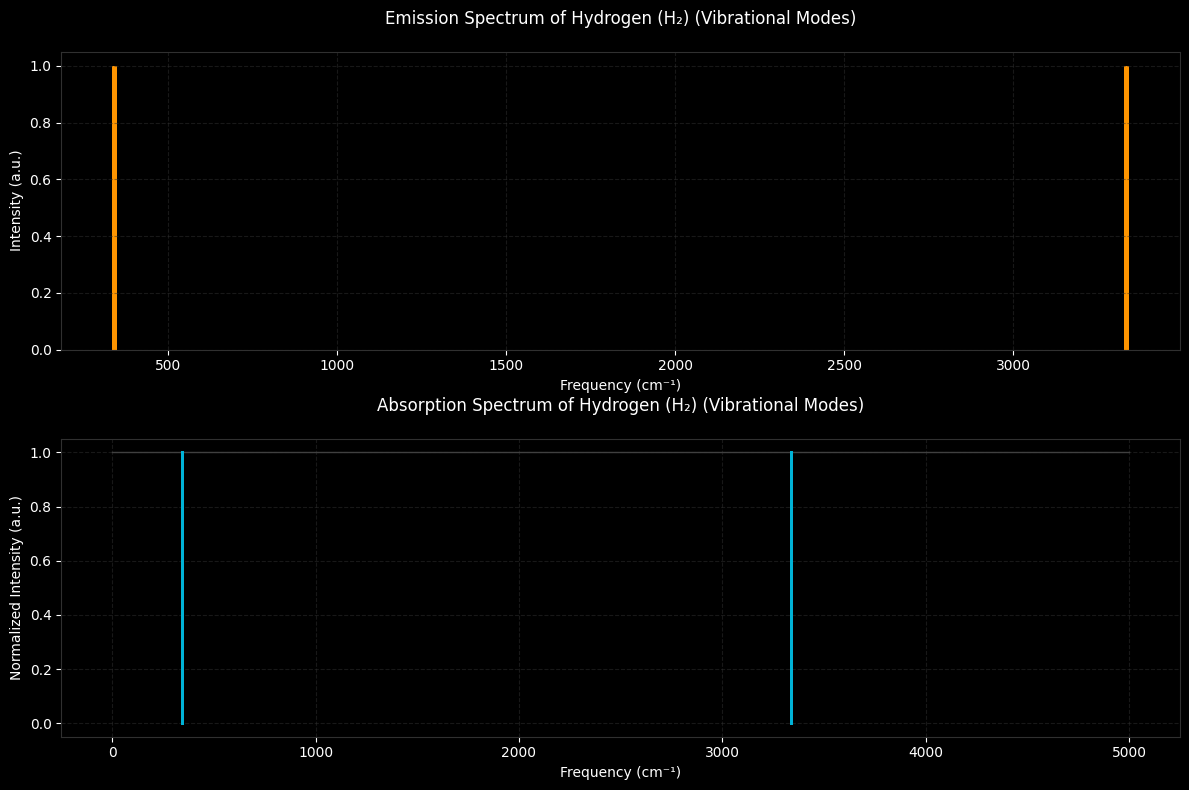

In [ ]:
# Emission and Absorption Spectra (Electronic Frequencies / Transitions)

mf = scf.RHF(mol)                                     # Perform a ground-state calculation for molecular vibrational frequencies
mf.kernel()
hess = hessian.RHF(mf).kernel()                       # Calculate the Hessian matrix (force constants)
frequencies = np.linalg.eigvalsh(hess)                # Diagonalize the Hessian to get vibrational frequencies
frequencies = np.sqrt(np.abs(frequencies)) * 5140.48  # Conversion factor to cm^-1 (more accurate)
frequencies = frequencies[(frequencies > 0) & (frequencies < 5000)]  # Filter out non-physical (imaginary) frequencies and limit to realistic range

# Plot stlyes
EMISSION_COLOR = '#ff9500'  # Bright orange
ABSORPTION_COLOR = '#00b4d8'  # Bright blue
BASELINE_COLOR = '#404040'  # Dark gray
GRID_COLOR = '#303030'  # Slightly lighter gray for grid
plt.figure(figsize=(12, 8), facecolor='black') # Create figure with dark background
plt.style.use('dark_background') # Set the style to dark background

# Emission Spectrum
plt.subplot(2, 1, 1)
plt.bar(frequencies, height=1.0, width=15.0, color=EMISSION_COLOR, alpha=0.8)
plt.xlabel('Frequency (cm⁻¹)', color='white', fontsize=10)
plt.ylabel('Intensity (a.u.)', color='white', fontsize=10)
plt.title(f'Emission Spectrum of {molecule} (Vibrational Modes)',
         color='white', pad=20, fontsize=12)

# Customize grid and spines
plt.grid(True, color=GRID_COLOR, linestyle='--', alpha=0.5)
for spine in plt.gca().spines.values():
    spine.set_color(GRID_COLOR)
plt.tick_params(colors='white')

# Absorption Spectrum
plt.subplot(2, 1, 2)
# Create baseline
plt.plot(np.linspace(0, 5000, 1000), np.ones(1000),
         color=BASELINE_COLOR, linewidth=1)

# Plot absorption lines with gradient effect
for freq in frequencies:
    y = np.linspace(0, 1, 100)
    x = np.ones_like(y) * freq
    plt.plot(x, y, color=ABSORPTION_COLOR,
            alpha=0.8, linewidth=2)

plt.xlabel('Frequency (cm⁻¹)', color='white', fontsize=10)
plt.ylabel('Normalized Intensity (a.u.)', color='white', fontsize=10)
plt.title(f'Absorption Spectrum of {molecule} (Vibrational Modes)',
         color='white', pad=20, fontsize=12)

# Customize grid and spines
plt.grid(True, color=GRID_COLOR, linestyle='--', alpha=0.5)
for spine in plt.gca().spines.values():
    spine.set_color(GRID_COLOR)
plt.tick_params(colors='white')

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Set figure background to black
plt.gcf().patch.set_facecolor('black')

plt.show()